To zip datafolders:

* zip -r -X zipname.zip images data.csv

________
CH Script

In [ ]:
!python unet_nuclei.py --data_file ../data/nuclei/nuclei_train.npz \
--epochs 10 \
--batch_size 28 \
--shape 256 \
--workers 12 \
--patience_stop 20 \
--patience_lr 10 \
--preprocess_for vgg16 \
--local

In [3]:
!zip -r -X unet_model.zip unet_nuclei.py

updating: unet_nuclei.py (deflated 72%)


_____

### Setup

In [1]:
from ibmcloud_api import IBMCloudAPI
from keras.models import load_model
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import json

Using TensorFlow backend.


### IBM Cloud Setup

In [2]:
cos_credentials = {
  "apikey": "ftIWPpG8LpqDtntew59ckZcQs-qbEER1oJHWgVI2rHX3",
  "cos_hmac_keys": {
    "access_key_id": "db63540372394a2bb6e4270bca041bb8",
    "secret_access_key": "293fce31ec8287a4f1ffdd00ef02638047112dd957db4c0c"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/7fec468bf3b9a2181d714162d559c6e4:ab8fce54-b276-43ff-b3ce-8d04d858f79f::",
  "iam_apikey_name": "auto-generated-apikey-db635403-7239-4a2b-b6e4-270bca041bb8",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/7fec468bf3b9a2181d714162d559c6e4::serviceid:ServiceId-a76bc3a3-acfd-466c-9009-68028fc914be",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/7fec468bf3b9a2181d714162d559c6e4:ab8fce54-b276-43ff-b3ce-8d04d858f79f::"
}
cos_service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

wml_credentials = {
  "apikey": "z_xmW8qw7lU3u4yNxS_wsUD-1EtgW48JKw9n9sQsS7hF",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/7fec468bf3b9a2181d714162d559c6e4:3769e702-a12f-4a0c-bac0-19656fcd56ff::",
  "iam_apikey_name": "auto-generated-apikey-6a740a92-1aae-489f-97af-fcac2079f94c",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/7fec468bf3b9a2181d714162d559c6e4::serviceid:ServiceId-cb89dede-3126-4699-aaa2-5956523d4527",
  "instance_id": "3769e702-a12f-4a0c-bac0-19656fcd56ff",
  "password": "675440b4-85ab-4198-bf68-753e4b4495f0",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "6a740a92-1aae-489f-97af-fcac2079f94c"
}

api = IBMCloudAPI(cos_credentials, cos_service_endpoint, wml_credentials)

#### Data

In [2]:
dataset = "nuclei"
data_bucket = dataset + "-data"
result_bucket = dataset + "-result"

data_bucket_endpoint_private = "s3-api.us-geo.objectstorage.service.networklayer.com"
data_bucket_endpoint_public = "s3-api.us-geo.objectstorage.softlayer.net"
result_bucket_endpoint_private = "s3-api.us-geo.objectstorage.service.networklayer.com"
result_bucket_endpoint_public = "s3-api.us-geo.objectstorage.softlayer.net"

In [3]:
buckets = {
    "data_bucket":{
        "name":data_bucket,
        "endpoint":data_bucket_endpoint_private
    },
    "result_bucket":{
        "name":result_bucket,
        "endpoint":result_bucket_endpoint_private
    }
}

### Training

In [4]:
definition_name = "UNET-{}-b16".format(dataset)

In [8]:
definition_uid, run_uid = api.train_in_cloud(
    "unet_model.zip",
    buckets,
    definition_name,
    asynchronous=True,
    log=False,
    command=[
        "python unet_nuclei.py",
        "--data_file nuclei_train_val.npz",
        "--epochs 200",
        "--batch_size 16",
        "--shape 256",
        "--patience_stop 50"
    ]
)

definition_uid:  86e995c5-7b81-4c44-afe1-4f6f437a700c
Run uid:  model-l057klro
Run details:
{
 "metadata": {
  "guid": "model-l057klro",
  "url": "/v3/models/model-l057klro",
  "created_at": "2018-12-14T11:26:24Z",
  "modified_at": "2018-12-14T11:26:24Z"
 },
 "entity": {
  "model_definition": {
   "framework": {
    "name": "tensorflow",
    "version": "1.5"
   },
   "name": "(Training) UNET-nuclei-b16",
   "definition_href": "https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/86e995c5-7b81-4c44-afe1-4f6f437a700c",
   "execution": {
    "command": "python unet_nuclei.py --data_file nuclei_train_val.npz --epochs 200 --batch_size 16 --shape 256 --patience_stop 50",
    "compute_configuration": {
     "name": "k80"
    }
   }
  },
  "training_data_reference": {
   "type": "s3",
   "connection": {
    "endpoint_url": "s3-api.us-geo.objectstorage.service.networklayer.com",
    "aws_access_key_id": "db63540372394a2bb6e4270bca041bb8",
    "aws_secret_access_key": "293fce31ec8

In [9]:
status = api.training_status(run_uid)

print(status["state"])
for i in range(0, len(status["metrics"])-1, 2):
    it = status["metrics"][i]["iteration"]
    val, train = status["metrics"][i]["values"][0]["value"], status["metrics"][i+1]["values"][0]["value"]
    print("Epoch {}\n- Training loss: {:.6f} - Validation loss: {:.6f}".format(it, train, val))

running


##### Logs

In [6]:
api.download_latest_training_log(result_bucket, "training-log-{}.txt".format(definition_name))

downloading training-Z1Yy68Eig/learner-1/training-log.txt to training-log-UNET-nuclei-b16.txt... done


In [ ]:
!cat training-log-UNET-nuclei-b16.txt

### Predict a test sample

In [5]:
model_path = "models/" + definition_name
api.download_best_checkpoint(result_bucket, model_path + ".modelckpt")

In [6]:
from unet_nuclei import dice_coef
data = np.load("../data/nuclei/nuclei_train_val.npz")
X_val, Y_val = data["X_val"], data["Y_val"]
model = load_model(model_path + ".modelckpt", custom_objects={'dice_coef':dice_coef})


In [9]:
model.evaluate(X_val, Y_val)

134/134 [==============================] - 31s 233ms/step


[0.06932407706531125, 0.8765217048018726]

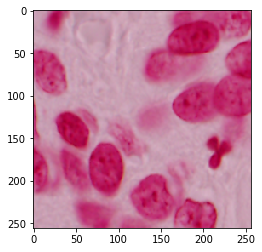

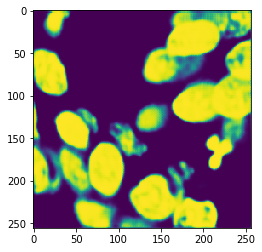

In [8]:
i = 0
plt.imshow(X_val[i])
plt.show()

pred = model.predict(X_val[i:i+1])

plt.imshow(pred[0,:,:,0])
plt.show()

### Deploy

### Warning: Delete definitions

In [8]:
api.cancel_training_run(run_uid)
api.delete_model_definition(definition_uid)
api.delete_training_definition(run_uid)
api.empty_cos_bucket(result_bucket)